In [1]:
import pandas as pd

From https://www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_06.pdf, Table 5 (a very lengthy table.

Year: 2015

In [165]:
import numpy as np
nan = np.nan

# per 100e3
_deaths = {
    "age": ["0-1", "1-4", "5-14", "15-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "85-95"],
    "alzheimers": [nan, nan, nan, nan, nan, nan, 0.2, 2.4, 22.4, 211.9, 1174.2],
    "influenza": [4.4, 0.6, 0.2, 0.4, 0.9, 1.7, 4.7, 11.3, 29.5, 101.6, 421.4],
    "suicide": [nan, nan, 1, 12.5, 15.7, 17.1, 20.3, 18.9, 15.2, 17.9, 19.4],
    "drug_overdoses": [0.7, 0.4, 0.1, 10.0, 28.0, 29.6, 31.9, 23.3, 8.1, 4.4, 5.6],
    "alcohol induced causes": [nan, nan, nan, 0.4, 3.2, 8.7, 21.6, 28.2, 19.1, 11.2, 5.8],
    "accidents": [32.5, 7.8, 3.7, 28.5, 44.8, 43.9, 49.8, 47.7, 47.0, 111.5, 364.5],
}
deaths = pd.DataFrame(_deaths).set_index("age")
deaths /= 100e3
deaths = deaths.drop(["0-1", "1-4"])
deaths.head(n=2)

,alzheimers,influenza,suicide,drug_overdoses,alcohol induced causes,accidents
age,,,,,,
5-14,NaN,0.000002,0.000010,0.000001,NaN,0.000037
15-24,NaN,0.000004,0.000125,0.000100,0.000004,0.000285


In [166]:
us_ages = pd.read_csv("static-data/us-age-pyramid.csv")
us_ages = us_ages.set_index("Age")
us_ages = us_ages.sum(axis=1).reset_index()
us_ages.columns = ["age", "population"]
us_ages = us_ages.set_index("age")
us_ages.loc["95-99"] += us_ages.loc["100+"]
us_ages = us_ages.drop("100+").reset_index()
us_ages.columns = ["age", "population"]
us_ages["min_age"] = us_ages.age.apply(lambda x: int(x.split("-")[0]))
us_ages["max_age"] = us_ages.age.apply(lambda x: int(x.split("-")[1]))
us_ages.tail()

,age,population,min_age,max_age
15,75-79,9727734,75,79
16,80-84,6461202,80,84
17,85-89,3911104,85,89
18,90-94,2051136,90,94
19,95-99,723740,95,99


In [167]:
def _get_ages(row, age_dist=None, catch=True):
    idx = (row.min_age <= age_dist.min_age) & (age_dist.max_age <= row.max_age)
    if catch:
        assert idx.sum() == 2
    return age_dist.loc[idx, "population"].sum()

In [168]:
us = pd.read_html("static-data/us-deaths-by-age.html")[0]
us = us.iloc[1:-1, 1:]
us.columns = ["age", "deaths", "percentage"]
us.loc[us.age == "Under 1", "age"] = "0-1"
us.loc[us.age == "85 and over", "age"] = "85-95"
us = us.set_index("age").drop(columns="percentage")
us["deaths"] = us["deaths"].astype(int)
us.loc["1-4"] += us.loc["0-1"]
us = us.drop("0-1")
us.loc["0-4"] = us.loc["1-4"]
us = us.drop("1-4")
us = us.reset_index()

us["min_age"] = us.age.apply(lambda x: int(x.split("-")[0]))
us["max_age"] = us.age.apply(lambda x: int(x.split("-")[1]))

us["population"] = us.apply(_get_ages, age_dist=us_ages, catch=False, axis=1)
print(us.population.sum())
assert 330e6 <= us.population.sum() <= 330.3e6
us = us.set_index("age").drop("0-4")
us["death_rate"] = us["deaths"] / us["population"]
us

330278907


,deaths,min_age,max_age,population,death_rate
age,,,,,
5-14,16,5,14,41134639,3.889666e-07
15-24,190,15,24,43501653,4.367650e-06
25-34,935,25,34,46887809,1.994122e-05
35-44,2411,35,44,41910390,5.752750e-05
45-54,6566,45,54,40631605,1.615983e-04
55-64,15880,55,64,42211413,3.762016e-04
65-74,27166,65,74,32173890,8.443493e-04
75-84,34398,75,84,16188936,2.124784e-03
85-95,42663,85,95,5962240,7.155532e-03


In [169]:
covid = us["death_rate"]

In [170]:
deaths.index

Index(['5-14', '15-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84',
       '85-95'],
      dtype='object', name='age')

In [171]:
deaths2 = deaths.copy()
deaths["covid"] = covid
for l in covid.index:
    print(l)
    deaths2.loc[l] /= (covid.loc[l])
#     deaths2.loc[l] *= 5 / 12
deaths2
# deaths["covid"] = covid

5-14
15-24
25-34
35-44
45-54
55-64
65-74
75-84
85-95


,alzheimers,influenza,suicide,drug_overdoses,alcohol induced causes,accidents
age,,,,,,
5-14,NaN,5.141830,25.709149,2.570915,NaN,95.123853
15-24,NaN,0.915824,28.619509,22.895607,0.915824,65.252480
25-34,NaN,0.451327,7.873140,14.041269,1.604716,22.466030
35-44,NaN,0.295511,2.972491,5.145365,1.512320,7.631133
45-54,0.012376,0.290845,1.256201,1.974030,1.336647,3.081715
55-64,0.063796,0.300371,0.502390,0.619349,0.749598,1.267937
65-74,0.265293,0.349381,0.180020,0.095932,0.226210,0.556642
75-84,0.997278,0.478166,0.084244,0.020708,0.052711,0.524759
85-95,1.640968,0.588915,0.027112,0.007826,0.008106,0.509396


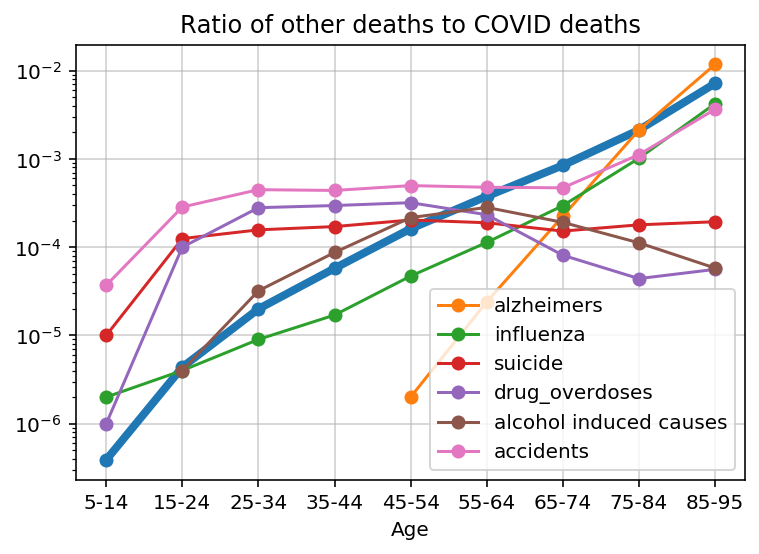

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
c = deaths["covid"]
c.plot(ax=ax, style="o-", linewidth=4)

ax = deaths[[c for c in deaths.columns if "covid" not in c]].plot(style="o-", ax=ax)
ax.grid(alpha=0.6)
ax.set_xlabel("Age")
# ax.plot(ax.get_xlim(), [1, 1])
ax.set_title("Ratio of other deaths to COVID deaths")
ax.set_yscale("log")

In [173]:
deaths2.columns

Index(['alzheimers', 'influenza', 'suicide', 'drug_overdoses',
       'alcohol induced causes', 'accidents'],
      dtype='object')

In [174]:
deaths2.index.tolist()

['5-14',
 '15-24',
 '25-34',
 '35-44',
 '45-54',
 '55-64',
 '65-74',
 '75-84',
 '85-95']

In [175]:
show = deaths2.reset_index().melt(id_vars="age", var_name="reason", value_name="ratio")

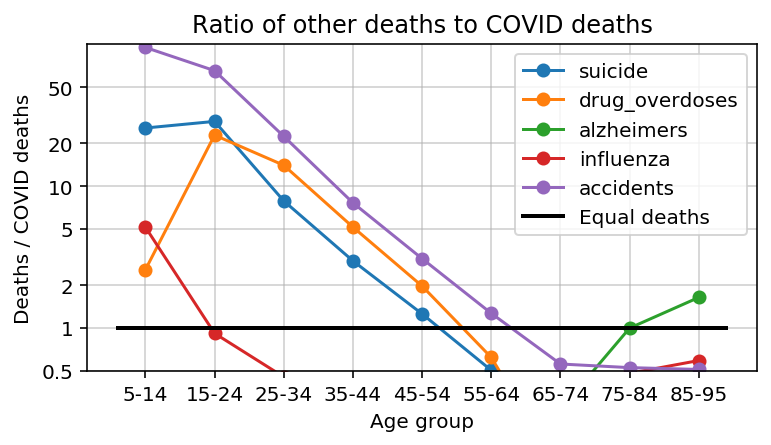

In [224]:
import seaborn as sns

w = 3
fig, ax = plt.subplots(figsize=(2.0 * w, w))
show = ["suicide", "drug_overdoses", "alzheimers", "influenza", "accidents"]# "alcohol induced causes"]

# show = ["suicide", "drug_overdoses", "influenza", "accidents"]
# ax = deaths2[show].plot(style="o-", ax=ax)

for s in show:
    t = deaths2[s]
    ax.plot(t.index, t, "o-", label=s)

ax.plot(ax.get_xlim(), [1, 1], "black", linewidth=2, label="Equal deaths")
ax.legend(loc="best")
ax.grid(alpha=0.6)
ax.set_xlabel("Age")
ax.set_title("Ratio of other deaths to COVID deaths")
ax.set_xlabel("Age group")
ax.set_ylabel("Deaths / COVID deaths")
ax.set_ylim(0.5, None)
ax.set_yscale("log", basey=2)

# yticks = [1] + [20 * i for i in range(50)]
yticks = [[1 * 10**i, 2 * 10**i, 5 * 10**i] for i in range(-10, 10)]
yticks = sum(yticks, [])
ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x) if x >= 1 else float(x)))
fig.savefig("imgs/us-death-rates-covid.png", dpi=300, bbox_inches="tight")

(0.2, 43.133825396337095)

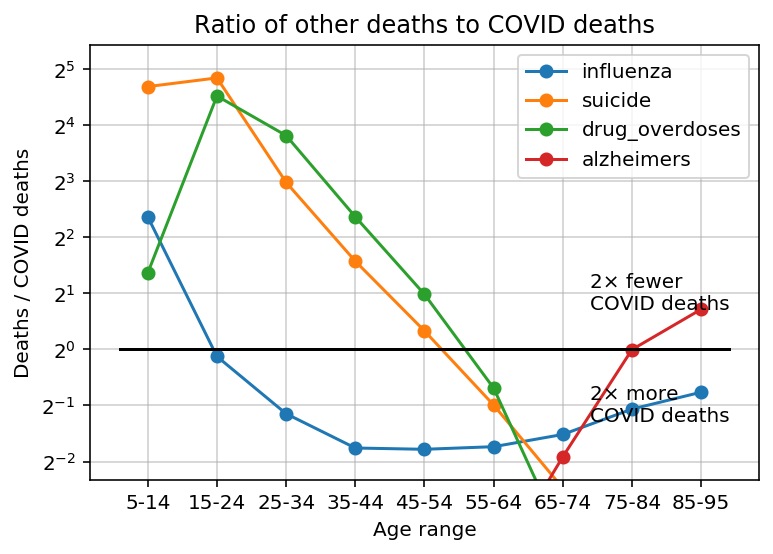

In [100]:
import seaborn as sns

show = ["influenza", "suicide", "drug_overdoses", "alzheimers"]
ax = deaths2[show].plot(style="o-")
ax.grid(alpha=0.6)
ax.set_xlabel("Age")
ax.plot(ax.get_xlim(), [1, 1], "black")
ax.text(6.4, 1 / 2 * 0.825, "2× more\nCOVID deaths")
ax.text(6.4, 2 * 0.825, "2× fewer\nCOVID deaths")
ax.set_title("Ratio of other deaths to COVID deaths")
ax.set_xlabel("Age range")
ax.set_ylabel("Deaths / COVID deaths")
ax.set_yscale("log", basey=2)
ax.set_ylim(2e-1, None)